In [1]:
import os
os.chdir("/home/guido/github/spectralgradients")

import torch
import numpy as np
from torch import nn

from src.synt_data import SyntDataset
from src.train.model import TimeModule
from src.metrics.evaluate import Wrapper
from src.posthoc.sgradients import SpectralGradients as SG, plot_sg

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import seaborn as sns
sns.set_theme(
    context='notebook', 
    style='darkgrid', 
    palette='deep', 
    font='sans-serif', 
    font_scale=1.2, 
    color_codes=True, 
    rc={'figure.figsize':(5, 2.5)}
) 

# print current directory
print(os.getcwd())

fs = 100
nperseg = 100
nyquist = fs/2
Q = 5

setups = [0, 1, 2]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

explain_class = 1
# load the data


/home/guido/github/spectralgradients


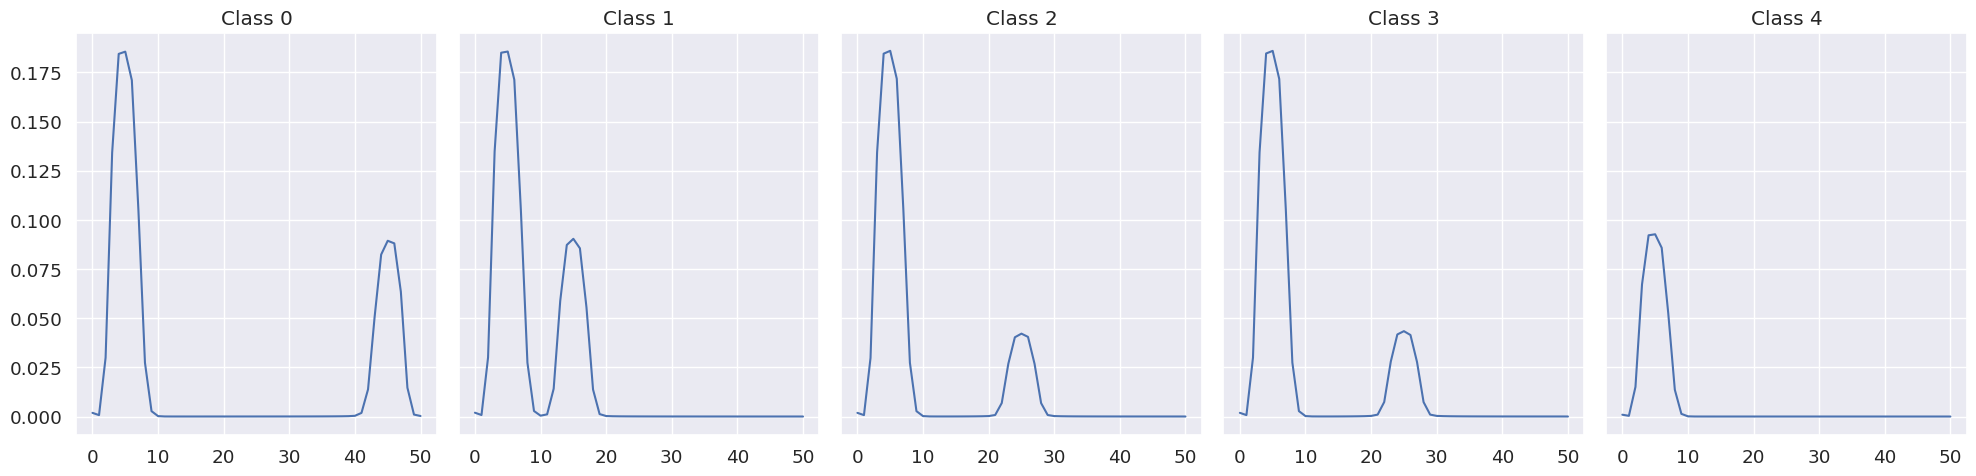

tensor(1) tensor([[5.3678e-04, 9.9917e-01, 1.0383e-05, 2.8093e-05, 2.5269e-04]],
       device='cuda:0', grad_fn=<ViewBackward0>)


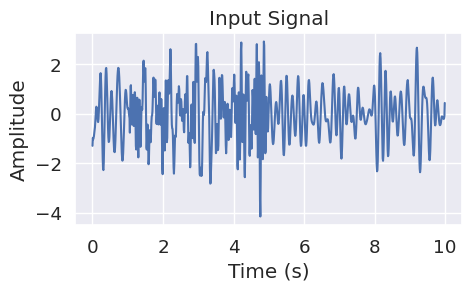

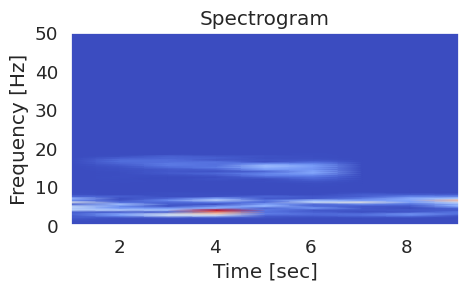

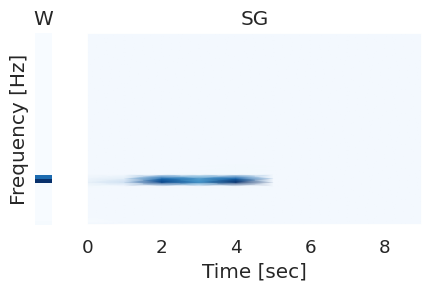

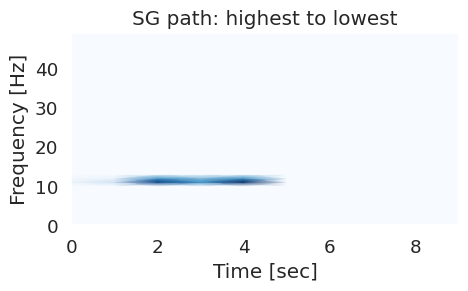

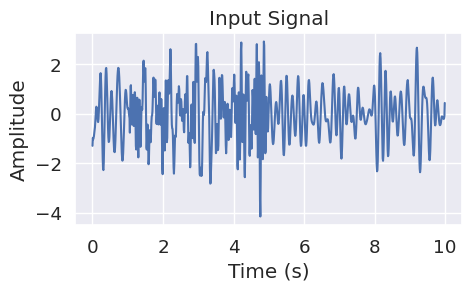

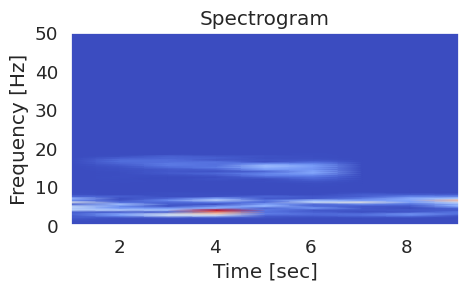

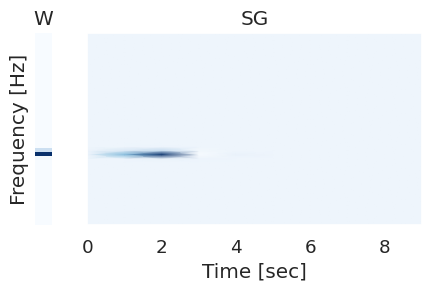

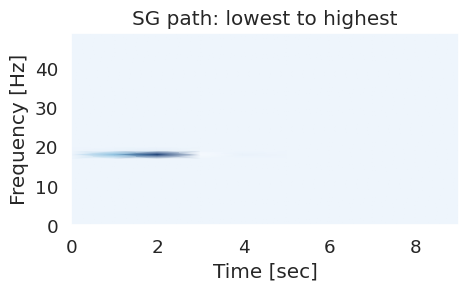

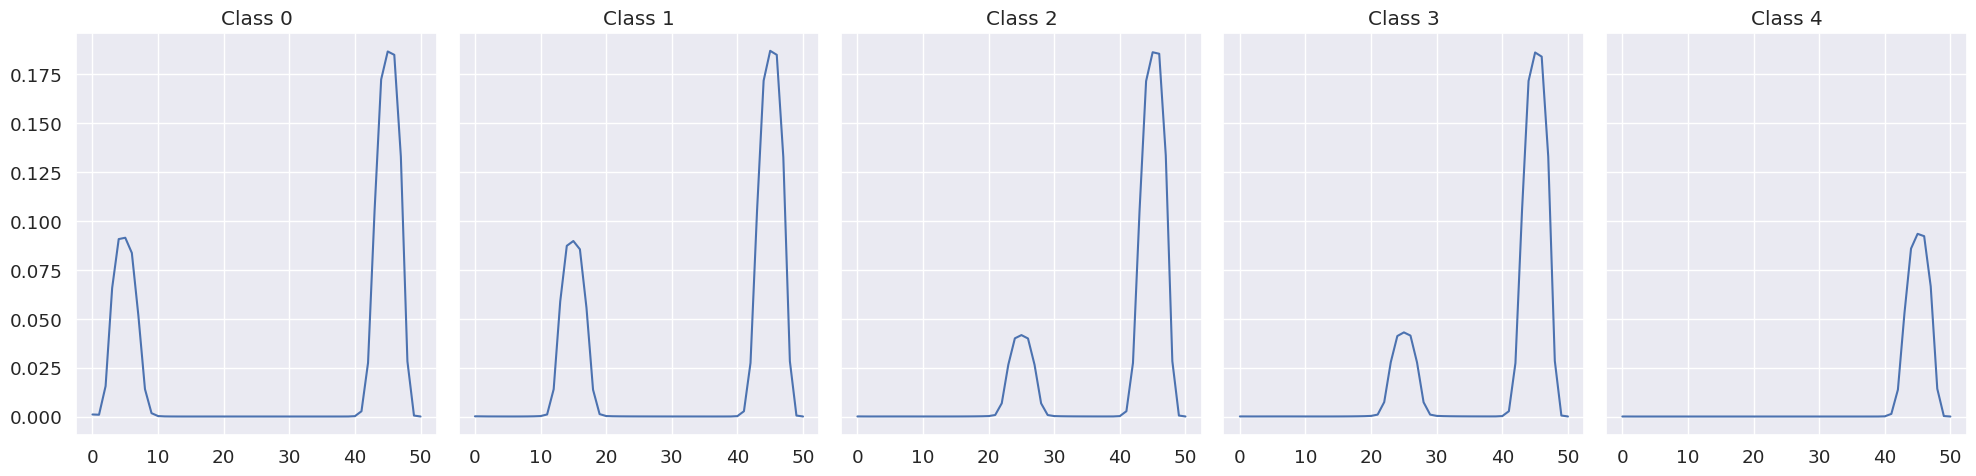

tensor(1) tensor([[5.2208e-05, 9.9985e-01, 2.8211e-07, 4.3700e-06, 9.0027e-05]],
       device='cuda:0', grad_fn=<ViewBackward0>)


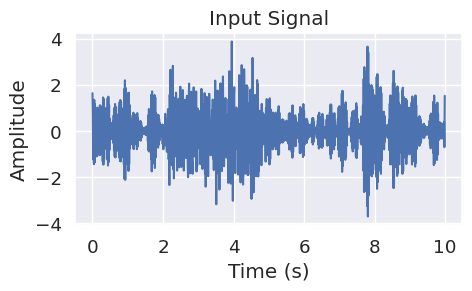

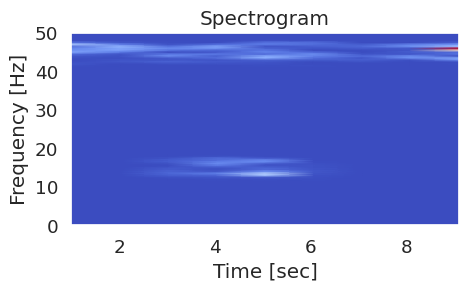

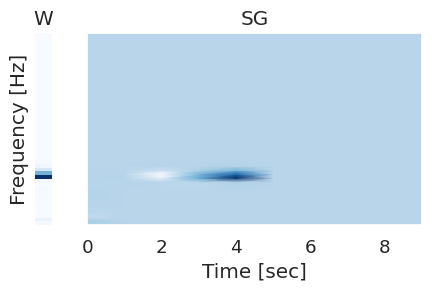

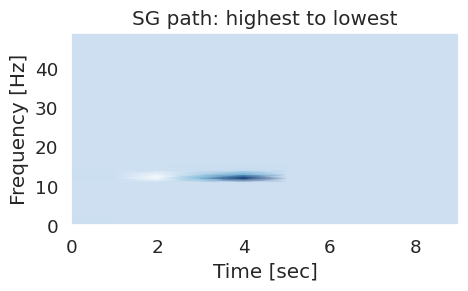

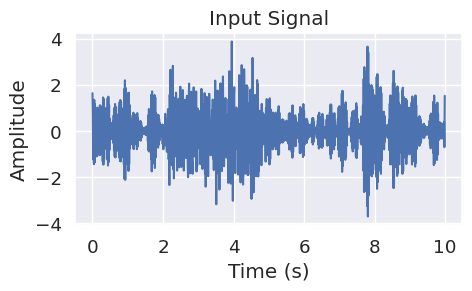

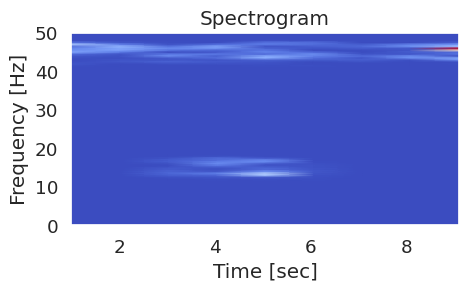

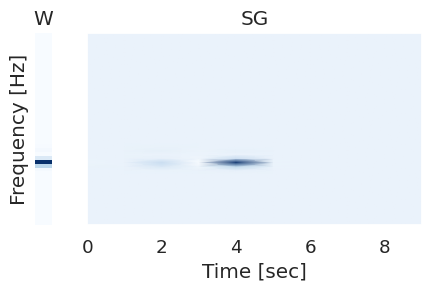

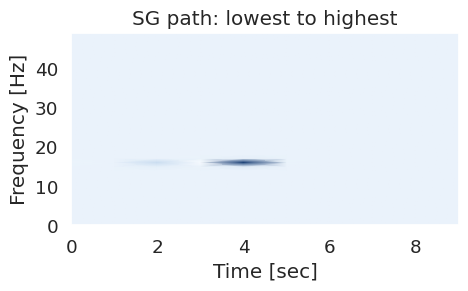

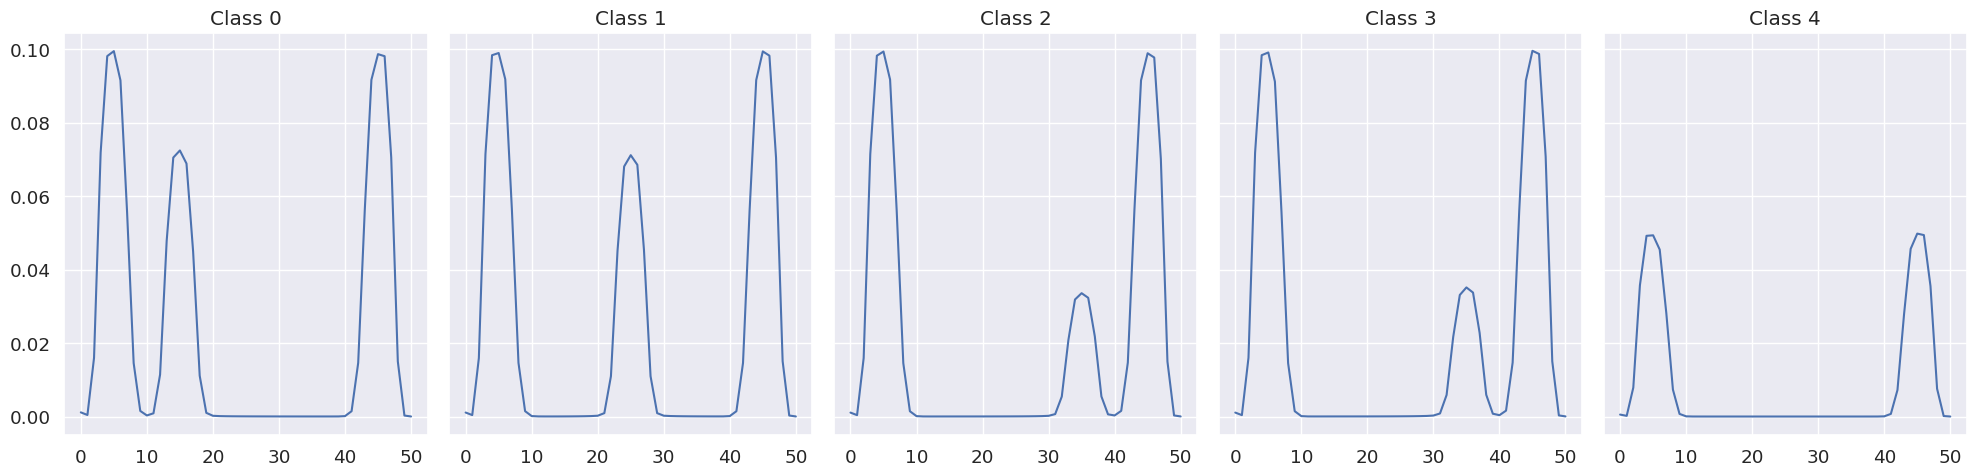

tensor(1) tensor([[1.6492e-05, 9.9825e-01, 2.0350e-05, 8.0966e-04, 8.9975e-04]],
       device='cuda:0', grad_fn=<ViewBackward0>)


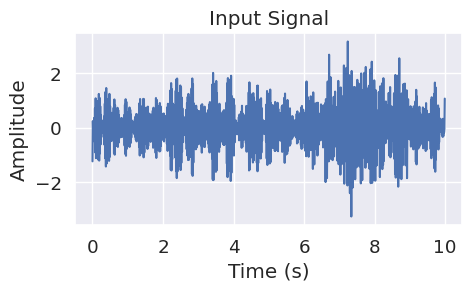

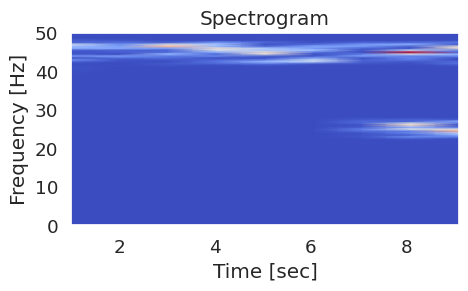

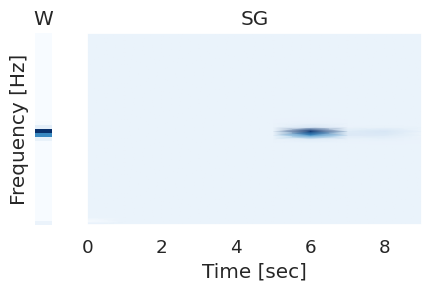

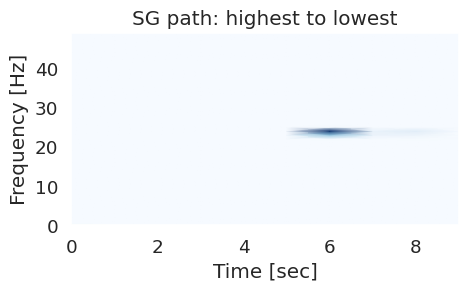

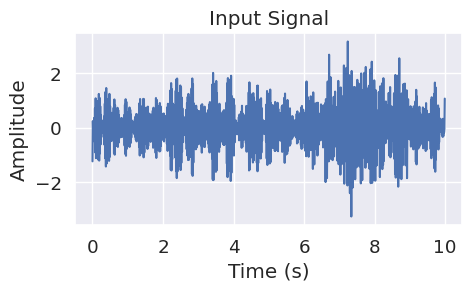

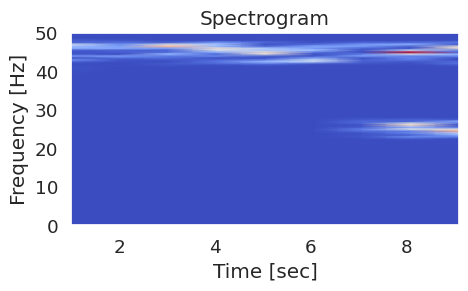

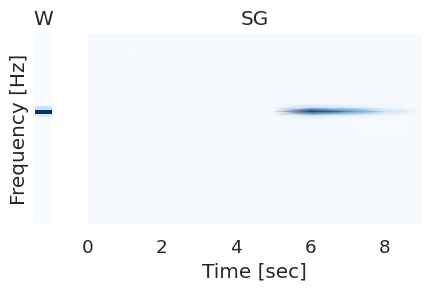

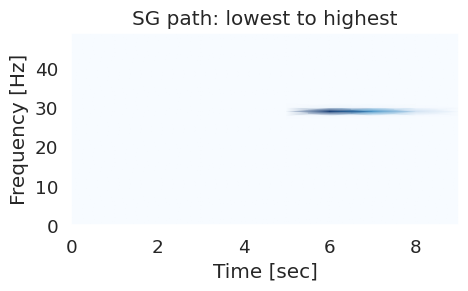

In [2]:
for setup in setups:

    dataset = SyntDataset(setup = setup, nperseg=nperseg, return_mask=True)

    model = TimeModule.load_from_checkpoint( f"output/model/setup{setup}/checkpoint.ckpt", 
        model = "conv",
        input_shape = dataset[0][0].shape,
        fs = fs,
        n_classes = dataset.n_class,
        ).eval()

    model = Wrapper(
        model,
        input_shape=dataset[0][0].shape,
    ).to(device)
    
    os.makedirs(f"output/model/setup{setup}/plots/lowest/", exist_ok=True)
    os.makedirs(f"output/model/setup{setup}/plots/highest/", exist_ok=True)

    ### plot class powers descriptions ###
    class_powers = dataset.mean_power.numpy() 
    Fregs = np.arange( 0, nyquist + fs/nperseg, fs/nperseg )

    fig, axes = plt.subplots( 1, dataset.n_class, figsize = (20, 5), sharex=True, sharey=True)

    for i in range(dataset.n_class):
        sns.lineplot(x = Fregs, y = class_powers[i], ax = axes[i])
        axes[i].set_title( f"Class {i}" )

    plt.tight_layout()
    plt.show()

    #### get a sample of class target ###

    idx = 0
    while True:
        signal, mask, target = dataset[idx]

        if mask.sum() / len(mask) <= .5 and target == explain_class:
            break

        idx = idx + 1

    print( target, model( signal.unsqueeze(0).to(device) ) )


    # plot SG 

    sg = SG(
        f = model,
        fs = fs,
        Q = 5,
        nperseg = nperseg,
        strategy = "highest",
        n_points = 10
    ) 

    plot_sg(
        SG=sg.to(device),
        signal=signal.to(device),
        label = target.item(),
        fs = fs,
        nperseg = nperseg,
        save_path = f"output/model/setup{setup}/plots/highest/"
    )

    sg = SG(
        f = model,
        fs = fs,
        Q = 5,
        nperseg = nperseg,
        strategy = "lowest",
        n_points = 10
    ) 

    plot_sg(
        SG=sg.to(device),
        signal=signal.to(device),
        label = target.item(),
        fs = fs,
        nperseg = nperseg,
        save_path = f"output/model/setup{setup}/plots/lowest/"
    )